In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset

# Load and Format the Data

In [3]:
directory = "results/transpositions-during-linear-homotopy-between-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

#df = pd.concat([pd.read_pickle(path) for path in tqdm(paths)])
df = []
errs = {}
for path in tqdm(paths):
    try:
        df.append(pd.read_pickle(path))
    except Exception as err:
        errs.update({path: err})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of corrupted files:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 110/110 [00:29<00:00,  3.67it/s]


df.shape = (37711, 30)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,index 0,index 1,cell 0,cell 1,dim,...,birth_relation_cell_similarity,birth_relation_index_similarity,death_relation_cell_similarity,death_relation_index_similarity,poset_arc_cell_similarity,poset_arc_index_similarity,poset_node_cell_similarity,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity
0,2025-06-18 16:08:54.780541,2025-06-18 16:08:54.771944,1,4,"(4,)",2,3,"((0,),)","((1,),)",0,...,None,None,None,None,None,None,None,None,None,None
1,2025-06-18 16:08:54.780541,2025-06-18 16:08:54.771944,1,4,"(4,)",1,2,"((1,),)","((3,),)",0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2025-06-18 16:08:54.780541,2025-06-18 16:08:54.771944,1,4,"(4,)",4,5,"((1,), (2,))","((2,), (3,))",1,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.2,0.0,0.0
3,2025-06-18 16:08:54.780541,2025-06-18 16:08:54.771944,1,4,"(4,)",5,6,"((1,), (2,))","((3,), (0,))",1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,1.0,1.0
4,2025-06-18 16:08:54.780541,2025-06-18 16:08:54.771944,1,4,"(4,)",5,6,"((2,), (3,))","((3,), (0,))",1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,1.0,1.0


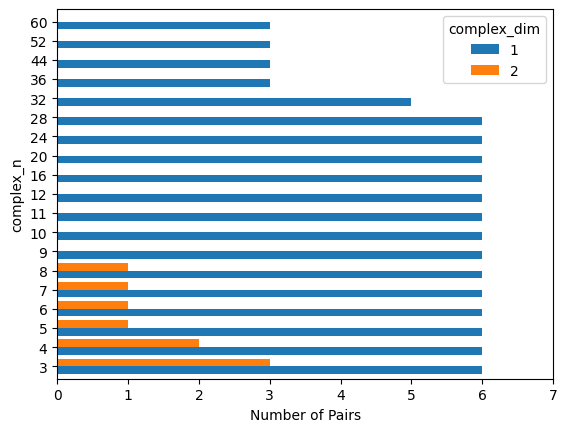

In [4]:
df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n']
           )['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().pivot_table(columns='complex_dim', index='complex_n', values='complex_index0').fillna(0).astype(int).plot(kind='barh', width=0.8)

plt.xlabel('Number of Pairs')
xticks, _ = plt.xticks()
xticks = np.unique(np.array(xticks).astype(int))
plt.xticks(xticks)

plt.show()

,type,switch,switch type
0,birth-birth,no switch,no switch
1,birth-birth,no switch,no switch
2,death-death,no switch,no switch
3,death-death,no switch,no switch
4,death-death,no switch,no switch
...,...,...,...
1680,death-death,switch,death-death
1681,death-death,no switch,no switch
0,birth-birth,switch,birth-birth
1,birth-unpaired,undefined,undefined


<>:19: SyntaxWarning: invalid escape sequence '\;'
<>:19: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_20552/1060707804.py:19: SyntaxWarning: invalid escape sequence '\;'
  axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')


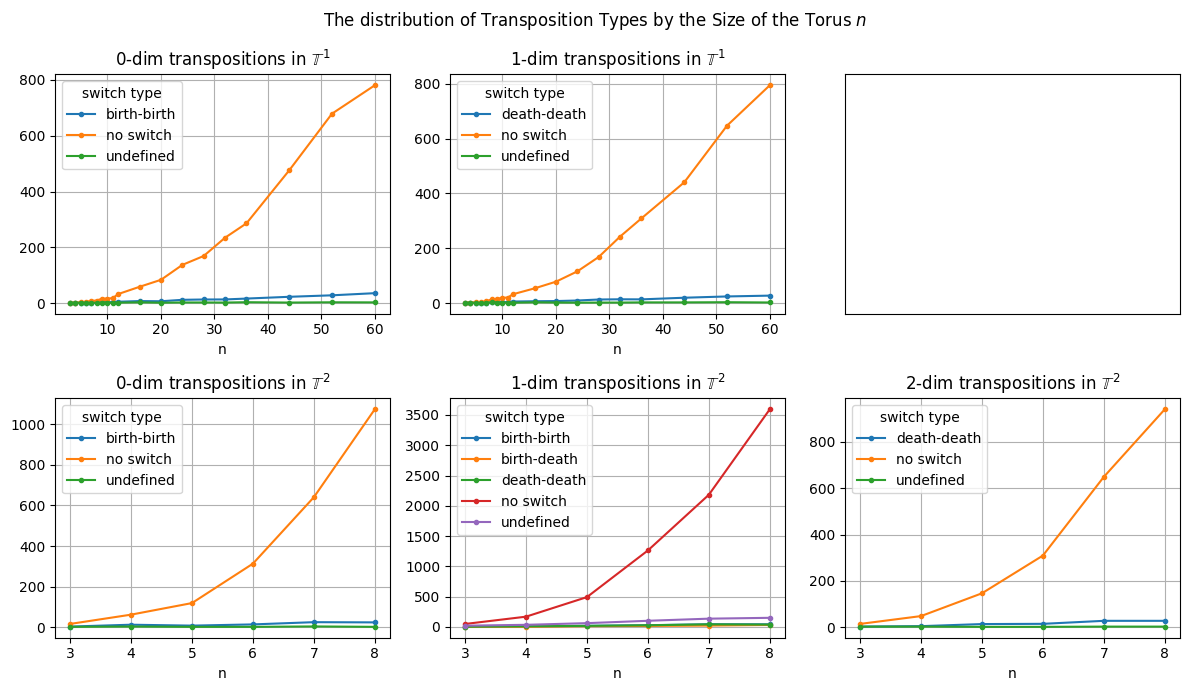

In [45]:
df_switch_types = df.copy()

df_switch_types.loc[(df_switch_types['switch'] == 'switch forward') | (df_switch_types['switch'] == 'switch backward'), 'switch'] = 'switch'
df_switch_types['switch type'] = df_switch_types.apply(lambda row: row['type'] if row['switch'] == 'switch' else row['switch'], axis=1)

df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
df_switch_types = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
df_switch_types = df_switch_types.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

fig, axs = plt.subplots(len(complex_dims), len(transposition_dims), figsize=(4*len(transposition_dims), 3*len(complex_dims) + 1))
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$')
for i, complex_dim in enumerate(complex_dims):
    for j, transposition_dim in enumerate(transposition_dims):
        try:
            df_switch_types[complex_dim][transposition_dim].plot(ax=axs[i, j], marker='.')
            axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
            axs[i, j].grid(True)
            axs[i, j].set_xlabel('n')
        except KeyError:
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
plt.tight_layout()
